This script will lot for the 50 smples fire polygons in anna good polygons the NDSI 30 day intervals available, the the final NDSI compositie, the final monthly compsoite, the final old composite, and target of y, and the combined ndsi, combined monthly and combined old predictoins as a multi panel plot.  I will also make plots with the counts in each interval for the NDSI to see how much imagery is even available

In [1]:
import os 
os.environ["SM_FRAMEWORK"] = "tf.keras"
import rioxarray
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL.Image
import tensorflow as tf
from MightyMosaic import MightyMosaic
import segmentation_models as sm
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap, BoundaryNorm

2024-09-30 13:12:02.171735: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-30 13:12:02.371778: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Segmentation Models: using `tf.keras` framework.


Read in the models

In [2]:
#combined old model
model_1 = tf.keras.models.load_model("/explore/nobackup/people/spotter5/cnn_mapping/Russia/models/combined_good.tf", 
                                           custom_objects={'precision':sm.metrics.Precision(threshold=0.5), 
                                                           'recall':sm.metrics.Recall(threshold = 0.5),
                                                            'f1-score': sm.metrics.FScore(threshold=0.5),
                                                             'iou_score': sm.metrics.IOUScore(threshold=0.5)})

# model_1 = tf.keras.models.load_model("/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/models/nbac_mtbs_regularize_50_global_norm.tf", 
#                                            custom_objects={'precision':sm.metrics.Precision(threshold=0.5), 
#                                                            'recall':sm.metrics.Recall(threshold = 0.5),
#                                                             'f1-score': sm.metrics.FScore(threshold=0.5),
#                                                              'iou_score': sm.metrics.IOUScore(threshold=0.5)})

#combined monthl model
model_2 = tf.keras.models.load_model("/explore/nobackup/people/spotter5/cnn_mapping/Russia/models/combined_good_85.tf", 
                                           custom_objects={'precision':sm.metrics.Precision(threshold=0.5), 
                                                           'recall':sm.metrics.Recall(threshold = 0.5),
                                                            'f1-score': sm.metrics.FScore(threshold=0.5),
                                                             'iou_score': sm.metrics.IOUScore(threshold=0.5)})

# model_3 = tf.keras.models.load_model("/explore/nobackup/people/spotter5/cnn_mapping/Russia/models/combined_good_ndsi.tf", 
#                                            custom_objects={'precision':sm.metrics.Precision(threshold=0.5), 
#                                                            'recall':sm.metrics.Recall(threshold = 0.5),
#                                                             'f1-score': sm.metrics.FScore(threshold=0.5),
#                                                              'iou_score': sm.metrics.IOUScore(threshold=0.5)})

model_3 = tf.keras.models.load_model(f"/explore/nobackup/people/spotter5/cnn_mapping/Russia/models/russia_good_no_regularize_ndsi_{2}.tf", 
                                           custom_objects={'precision':sm.metrics.Precision(threshold=0.5), 
                                                           'recall':sm.metrics.Recall(threshold = 0.5),
                                                            'f1-score': sm.metrics.FScore(threshold=0.5),
                                                             'iou_score': sm.metrics.IOUScore(threshold=0.5)})

# #combined ndsi model


2024-09-30 13:12:15.496256: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-30 13:12:15.857152: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31134 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:61:00.0, compute capability: 7.0
2024-09-30 13:12:15.857833: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 31134 MB memory:  -> device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0000:62:00.0, compute capability: 7.0
2024-09-30 13:12:15.858371: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device 

In [3]:
# Initialization code
min_max = pd.read_csv("/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/l8_sent_collection2_global_min_max_cutoff_proj.csv").reset_index(drop=True)
min_max = min_max[['6', '7', '8']]

from sklearn.preprocessing import MinMaxScaler

# Fit the scaler once on the min_max data
scaler = MinMaxScaler()
scaler.fit(min_max)

def norm(img):
    # Select relevant bands
    if img.shape[2] == 4:
        img = img[:, :, :-1]
    else:
        img = img[:, :, 6:9]
    
    # Ensure data is float and round
    img = img.astype(float)
    img = np.round(img, 3)
    img[img == 0] = -999
    img[np.isnan(img)] = -999
    img[img == -999] = np.nan
    
    in_shape = img.shape
    
    # Reshape and turn into DataFrame
    img = img.reshape(img.shape[0] * img.shape[1], img.shape[2])
    img = pd.DataFrame(img, columns=min_max.columns)
    
    # Concatenate with min_max for consistent scaling
    img = pd.concat([min_max, img]).reset_index(drop=True)
    
    # Apply the pre-fitted scaler
    img = pd.DataFrame(scaler.transform(img))
    
    # Remove the added min_max rows
    img = img.iloc[len(min_max):]
    
    # Reshape back to original shape
    img = img.values.reshape(in_shape)
    img[np.isnan(img)] = -1
    
    return img

# Rest of your code follows, including the loop over polygon IDs
# The norm function will now consistently transform the data without issues across iterations


Looop through and save plots, script will autmatically adjust depending how many intervals we have. 

2024-09-17 10:58:30.692091: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2024-09-17 10:58:36.306460: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-09-17 10:58:36.307388: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-09-17 10:58:36.307418: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:85] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2024-09-17 10:58:36.307991: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-09-17 10:58:36.308043: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


1/1 [==============================] - 1s 1s/step
Saved Plot 52
1/1 [==============================] - 1s 1s/step
Saved Plot 168
1/1 [==============================] - 0s 50ms/step
Saved Plot 995
1/1 [==============================] - 0s 40ms/step
Saved Plot 1016
1/1 [==============================] - 0s 45ms/step
Saved Plot 1023
1/1 [==============================] - 0s 47ms/step
Saved Plot 1498
1/1 [==============================] - 0s 48ms/step
Saved Plot 1559
1/1 [==============================] - 0s 36ms/step
Saved Plot 1563
1/1 [==============================] - 0s 87ms/step
Saved Plot 1679
1/1 [==============================] - 0s 53ms/step
Saved Plot 1754
1/1 [==============================] - 0s 39ms/step
Saved Plot 1778
1/1 [==============================] - 0s 66ms/step
Saved Plot 2460


2024-09-17 11:03:24.505856: W tensorflow/core/kernels/gpu_utils.cc:50] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.


1/1 [==============================] - 0s 173ms/step
Saved Plot 2464
1/1 [==============================] - 0s 48ms/step
Saved Plot 2488
1/1 [==============================] - 0s 48ms/step
Saved Plot 3026
1/1 [==============================] - 0s 143ms/step
Saved Plot 3138
1/1 [==============================] - 0s 47ms/step
Saved Plot 3249
1/1 [==============================] - 0s 159ms/step
Saved Plot 3266
1/1 [==============================] - 0s 29ms/step
Saved Plot 3336
1/1 [==============================] - 0s 97ms/step
Saved Plot 3381
1/1 [==============================] - 0s 90ms/step
Saved Plot 3645
1/1 [==============================] - 0s 29ms/step
Saved Plot 4518
1/1 [==============================] - 0s 29ms/step
Saved Plot 5311
1/1 [==============================] - 0s 40ms/step
Saved Plot 5658
1/1 [==============================] - 0s 41ms/step
Saved Plot 7332
1/1 [==============================] - 0s 73ms/step
Saved Plot 7370
1/1 [==============================] - 0s 54m

IndexError: list index out of range

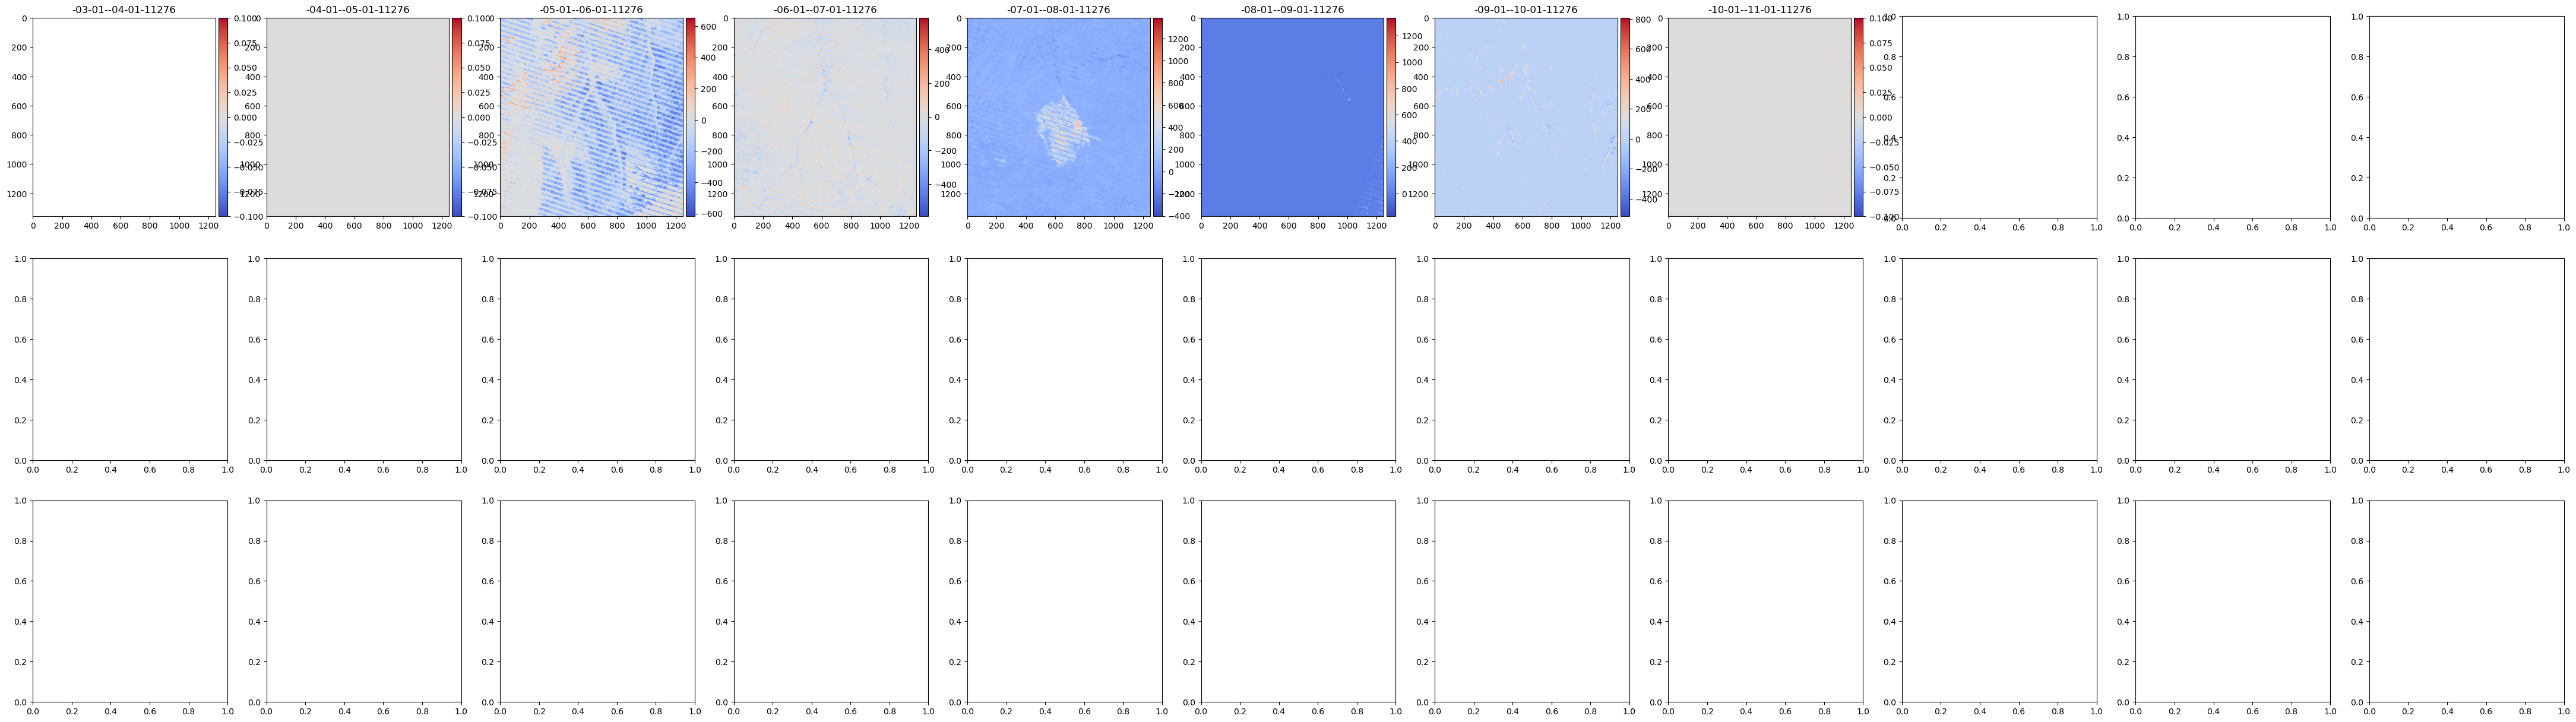

In [4]:
import os
import matplotlib.pyplot as plt
import rioxarray
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap, BoundaryNorm
import numpy as np

# Path to final monthly dnbr
monthly_dnbr_path = '/explore/nobackup/people/spotter5/cnn_mapping/Russia/monthly_intervals'

# Path to final old method dnbr
old_dnbr_path = '/explore/nobackup/people/spotter5/cnn_mapping/Russia/old_method'

# Define the save directory
save_dir = '/explore/nobackup/people/spotter5/cnn_mapping/Russia/old_monthly_ndsi_compare_plots/ndsi'
os.makedirs(save_dir, exist_ok=True)

# Define a binary colormap for final_y (0: black, 1: white)
binary_cmap = ListedColormap(['black', 'white'])
binary_norm = BoundaryNorm([-0.5, 0.5, 1.5], 2)  # To center the colors on 0 and 1

# Load the GeoDataFrame with all polygon IDs
gdf = gpd.read_file('/explore/nobackup/people/spotter5/cnn_mapping/Russia/anna_good_sampled.shp')

def extract_interval(file_name):
    # Extract the numerical part of the interval file name
    parts = file_name.split('_')
    return parts[0], parts[1]

for poly_id in gdf['ID'].unique():

    # if os.path.exists(os.path.join(save_dir, f'{poly_id}.png')) == False:

        # try:
    # if poly_id == 3266:
    
    in_path_ndsi = '/explore/nobackup/people/spotter5/cnn_mapping/Russia/ndsi_intervals'
    files_ndsi = [f for f in os.listdir(in_path_ndsi) if f.endswith('.tif')]
    this_id_files = [f for f in files_ndsi if f"_{poly_id}.tif" in f and '-06-01_-08-31' not in f]
    
    # Get interval files, excluding 'final'
    interval_files = [f for f in this_id_files if 'final' not in f]
    final_file = [f for f in this_id_files if 'final' in f]
    
    # Load and plot pre and post counts
    in_path_ndsi_counts = '/explore/nobackup/people/spotter5/cnn_mapping/Russia/ndsi_counts'
    files_ndsi_counts = [f for f in os.listdir(in_path_ndsi_counts) if f.endswith('.tif')]
    this_id_files_counts = [f for f in files_ndsi_counts if f"_{poly_id}.tif" in f and '-06-01_-08-31' not in f]
    
    # Sort both lists by interval
    interval_files_sorted = sorted(interval_files, key=extract_interval)
    this_id_files_counts_sorted = sorted(this_id_files_counts, key=extract_interval)

    # Ensure all interval_files are matched with counts and in order
    all_intervals = sorted(set(interval_files_sorted + this_id_files_counts_sorted), key=extract_interval)

         # Prepare the colormap and normalization for the counts
    unique_counts = set()
    for count_file in this_id_files_counts_sorted:
        counts = rioxarray.open_rasterio(os.path.join(in_path_ndsi_counts, count_file)).to_numpy()
        counts_pre = np.moveaxis(counts, 0, 2)[:, :, 0]
        unique_counts.update(np.unique(counts_pre))
    unique_counts = sorted(unique_counts)

    if len(unique_counts) > 1:
        cmap_counts = ListedColormap(plt.get_cmap('tab20').colors[:len(unique_counts)])
        norm_counts = BoundaryNorm(np.arange(len(unique_counts) + 1) - 0.5, len(unique_counts))
    else:
        # Handle case with single unique count value (e.g., all zeros)
        unique_counts = [0, 1]  # Dummy values for norm
        cmap_counts = ListedColormap(['black', 'gray'])  # Just two colors
        norm_counts = BoundaryNorm([-0.5, 0.5, 1.5], 2)
        
    num_intervals = len(all_intervals)
    num_cols = num_intervals + 3  # Adjust columns: intervals + final dNBR, Y, Prediction
    fig, axes = plt.subplots(3, num_cols, figsize=(5 * num_cols, 15))  # Adjusted for 3 rows
    
    # Row 1: Plot NDSI interval images, NDSI dNBR, Y values, and NDSI prediction
    for i, interval_file in enumerate(all_intervals):
        if interval_file in interval_files_sorted:
            # Interval exists, load and plot
            interval = rioxarray.open_rasterio(os.path.join(in_path_ndsi, interval_file)).to_numpy()
            interval = np.moveaxis(interval, 0, 2)[:, :, 0]
        else:
            # Interval missing, create a NaN image
            counts_sample = rioxarray.open_rasterio(os.path.join(in_path_ndsi_counts, interval_file)).to_numpy()
            interval = np.full((counts_sample.shape[1], counts_sample.shape[2]), np.nan)
        
        im = axes[0, i].imshow(interval, cmap='coolwarm')
        divider = make_axes_locatable(axes[0, i])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im, cax=cax)
        axes[0, i].set_title(os.path.splitext(interval_file)[0].replace('_', '-'))
    
    # Plot final NDSI dNBR, Y values, and NDSI prediction in row 1
    final = rioxarray.open_rasterio(os.path.join(in_path_ndsi, final_file[0])).to_numpy()
    final = np.moveaxis(final, 0, 2)
    final_dnbr = final[:, :, 0]
    final_y = final[:, :, -1]
    
    im_dnbr = axes[0, num_intervals].imshow(final_dnbr, cmap='coolwarm')
    divider_dn = make_axes_locatable(axes[0, num_intervals])
    cax_dn = divider_dn.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im_dnbr, cax=cax_dn)
    axes[0, num_intervals].set_title('NDSI dNBR')
    
    im_y = axes[0, num_intervals + 1].imshow(final_y, cmap=binary_cmap, norm=binary_norm)
    divider_y = make_axes_locatable(axes[0, num_intervals + 1])
    cax_y = divider_y.append_axes("right", size="5%", pad=0.05)
    cb_y = fig.colorbar(im_y, cax=cax_y, ticks=[0, 1])
    cb_y.set_ticks([0, 1])
    cb_y.set_ticklabels(['0', '1'])
    axes[0, num_intervals + 1].set_title('Y')
    
    final_for_pred = norm(final)
    final_pred = model_3.predict(np.expand_dims(final_for_pred, axis=0))[0].squeeze()
    im_pred = axes[0, num_intervals + 2].imshow(final_pred, cmap='viridis', vmin=0, vmax=1)
    divider_pred = make_axes_locatable(axes[0, num_intervals + 2])
    cax_pred = divider_pred.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im_pred, cax=cax_pred)
    axes[0, num_intervals + 2].set_title('NDSI Prediction')
    
    # Row 2: Plot pre counts, monthly dNBR, and monthly predictions
    for i, count_file in enumerate(all_intervals):
        if count_file in this_id_files_counts_sorted:
            counts = rioxarray.open_rasterio(os.path.join(in_path_ndsi_counts, count_file)).to_numpy()
            counts_pre = np.moveaxis(counts, 0, 2)[:, :, 0]
        else:
            counts_pre = np.full((final_dnbr.shape[0], final_dnbr.shape[1]), np.nan)
        
        im_pre = axes[1, i].imshow(counts_pre, cmap=cmap_counts, norm=norm_counts)
        divider_pre = make_axes_locatable(axes[1, i])
        cax_pre = divider_pre.append_axes("right", size="5%", pad=0.05)
        cb_pre = fig.colorbar(im_pre, cax=cax_pre, ticks=np.arange(len(unique_counts)))
        cb_pre.set_ticks(np.arange(len(unique_counts)))
        cb_pre.set_ticklabels([str(val) for val in unique_counts])
        axes[1, i].set_title(f'{os.path.splitext(count_file)[0].replace("_", "-")} Pre Counts')
    
    monthly_dnbr_file = f"final_{poly_id}.tif"
    if os.path.exists(os.path.join(monthly_dnbr_path, monthly_dnbr_file)):
        monthly_dnbr = rioxarray.open_rasterio(os.path.join(monthly_dnbr_path, monthly_dnbr_file)).to_numpy()
        monthly_dnbr = np.moveaxis(monthly_dnbr, 0, 2)
        monthly_dnbr_band = monthly_dnbr[:, :, 0]
        im_monthly_dnbr = axes[1, num_intervals].imshow(monthly_dnbr_band, cmap='coolwarm')
        divider_monthly_dn = make_axes_locatable(axes[1, num_intervals])
        cax_monthly_dn = divider_monthly_dn.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im_monthly_dnbr, cax=cax_monthly_dn)
        axes[1, num_intervals].set_title('Monthly dNBR')
        
        monthly_for_pred = norm(monthly_dnbr)
        monthly_pred = model_2.predict(np.expand_dims(monthly_for_pred, axis=0))[0].squeeze()
        im_monthly_pred = axes[1, num_intervals + 2].imshow(monthly_pred, cmap='viridis', vmin=0, vmax=1)
        divider_monthly_pred = make_axes_locatable(axes[1, num_intervals + 2])
        cax_monthly_pred = divider_monthly_pred.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im_monthly_pred, cax=cax_monthly_pred)
        axes[1, num_intervals + 2].set_title('Monthly Prediction')
    
    # Row 3: Plot post counts, old method dNBR, and old predictions
    for i, count_file in enumerate(all_intervals):
        if count_file in this_id_files_counts_sorted:
            counts = rioxarray.open_rasterio(os.path.join(in_path_ndsi_counts, count_file)).to_numpy()
            counts_post = np.moveaxis(counts, 0, 2)[:, :, 1]
        else:
            counts_post = np.full((final_dnbr.shape[0], final_dnbr.shape[1]), np.nan)
        
        im_post = axes[2, i].imshow(counts_post, cmap=cmap_counts, norm=norm_counts)
        divider_post = make_axes_locatable(axes[2, i])
        cax_post = divider_post.append_axes("right", size="5%", pad=0.05)
        cb_post = fig.colorbar(im_post, cax=cax_post, ticks=np.arange(len(unique_counts)))
        cb_post.set_ticks(np.arange(len(unique_counts)))
        cb_post.set_ticklabels([str(val) for val in unique_counts])
        axes[2, i].set_title(f'{os.path.splitext(count_file)[0].replace("_", "-")} Post Counts')
    
    old_dnbr_file = f"final_{poly_id}.tif"
    if os.path.exists(os.path.join(old_dnbr_path, old_dnbr_file)):
        old_dnbr = rioxarray.open_rasterio(os.path.join(old_dnbr_path, old_dnbr_file)).to_numpy()
        old_dnbr = np.moveaxis(old_dnbr, 0, 2)
        old_dnbr_band = old_dnbr[:, :, 0]
        im_old_dnbr = axes[2, num_intervals].imshow(old_dnbr_band, cmap='coolwarm')
        divider_old_dn = make_axes_locatable(axes[2, num_intervals])
        cax_old_dn = divider_old_dn.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im_old_dnbr, cax=cax_old_dn)
        axes[2, num_intervals].set_title('Old Method dNBR')
        
        old_for_pred = norm(old_dnbr)
        old_pred = model_1.predict(np.expand_dims(old_for_pred, axis=0))[0].squeeze()
        im_old_pred = axes[2, num_intervals + 2].imshow(old_pred, cmap='viridis', vmin=0, vmax=1)
        divider_old_pred = make_axes_locatable(axes[2, num_intervals + 2])
        cax_old_pred = divider_old_pred.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im_old_pred, cax=cax_old_pred)
        axes[2, num_intervals + 2].set_title('Old Method Prediction')
    
    # Leave the remaining plots empty if needed
    for i in range(num_intervals, num_cols):
        axes[1, i].axis('off')
        axes[2, i].axis('off')
    
    # Remove the axis ticks and labels from all plots
    for ax_row in axes:
        for ax in ax_row:
            ax.set_xticks([])
            ax.set_yticks([])
    
    # Adjust layout to reduce the space between rows
    plt.subplots_adjust(hspace=0.3, wspace=0.17)
    plt.margins(0)
    # plt.show()
    # Save the plot
    output_path = os.path.join(save_dir, f'{poly_id}.png')
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
    
    # Close the figure to avoid memory issues in a loop
    plt.close(fig)
    print(f"Saved Plot {poly_id}")
        # except:
            # print(f"Poly ID {poly_id} failed")


In [ ]:
't'

Add another column to only show predictions >0.5 in the last column

In [5]:
import os
import matplotlib.pyplot as plt
import rioxarray
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap, BoundaryNorm
import numpy as np

# Path to final monthly dnbr
monthly_dnbr_path = '/explore/nobackup/people/spotter5/cnn_mapping/Russia/monthly_intervals'

# Path to final old method dnbr
old_dnbr_path = '/explore/nobackup/people/spotter5/cnn_mapping/Russia/old_method'

# Define the save directory
save_dir = '/explore/nobackup/people/spotter5/cnn_mapping/Russia/old_monthly_ndsi_compare_plots/ndsi'
os.makedirs(save_dir, exist_ok=True)

# Define a binary colormap for final_y (0: black, 1: white)
binary_cmap = ListedColormap(['black', 'white'])
binary_norm = BoundaryNorm([-0.5, 0.5, 1.5], 2)  # To center the colors on 0 and 1

# Load the GeoDataFrame with all polygon IDs
gdf = gpd.read_file('/explore/nobackup/people/spotter5/cnn_mapping/Russia/anna_good_sampled.shp')

def extract_interval(file_name):
    # Extract the numerical part of the interval file name
    parts = file_name.split('_')
    return parts[0], parts[1]

for poly_id in gdf['ID'].unique():

    in_path_ndsi = '/explore/nobackup/people/spotter5/cnn_mapping/Russia/ndsi_intervals'
    files_ndsi = [f for f in os.listdir(in_path_ndsi) if f.endswith('.tif')]
    this_id_files = [f for f in files_ndsi if f"_{poly_id}.tif" in f and '-06-01_-08-31' not in f]
    
    # Get interval files, excluding 'final'
    interval_files = [f for f in this_id_files if 'final' not in f]
    final_file = [f for f in this_id_files if 'final' in f]
    
    # Load and plot pre and post counts
    in_path_ndsi_counts = '/explore/nobackup/people/spotter5/cnn_mapping/Russia/ndsi_counts'
    files_ndsi_counts = [f for f in os.listdir(in_path_ndsi_counts) if f.endswith('.tif')]
    this_id_files_counts = [f for f in files_ndsi_counts if f"_{poly_id}.tif" in f and '-06-01_-08-31' not in f]
    
    # Sort both lists by interval
    interval_files_sorted = sorted(interval_files, key=extract_interval)
    this_id_files_counts_sorted = sorted(this_id_files_counts, key=extract_interval)

    # Ensure all interval_files are matched with counts and in order
    all_intervals = sorted(set(interval_files_sorted + this_id_files_counts_sorted), key=extract_interval)

    # Prepare the colormap and normalization for the counts
    unique_counts = set()
    for count_file in this_id_files_counts_sorted:
        counts = rioxarray.open_rasterio(os.path.join(in_path_ndsi_counts, count_file)).to_numpy()
        counts_pre = np.moveaxis(counts, 0, 2)[:, :, 0]  # Using the first band for counts_pre
        unique_counts.update(np.unique(counts_pre))
    unique_counts = sorted(unique_counts)

    if len(unique_counts) > 1:
        cmap_counts = ListedColormap(plt.get_cmap('tab20').colors[:len(unique_counts)])
        norm_counts = BoundaryNorm(np.arange(len(unique_counts) + 1) - 0.5, len(unique_counts))
    else:
        unique_counts = [0, 1]  # Dummy values for norm
        cmap_counts = ListedColormap(['black', 'gray'])  # Just two colors
        norm_counts = BoundaryNorm([-0.5, 0.5, 1.5], 2)

    num_intervals = len(all_intervals)
    num_cols = num_intervals + 4  # Adjust columns: intervals + final dNBR, Y, Prediction, Prediction > 0.5
    fig, axes = plt.subplots(3, num_cols, figsize=(5 * num_cols, 15))  # Adjusted for 3 rows
    
    # Row 1: Plot NDSI interval images, NDSI dNBR, Y values, and NDSI prediction
    for i, interval_file in enumerate(all_intervals):
        if interval_file in interval_files_sorted:
            interval = rioxarray.open_rasterio(os.path.join(in_path_ndsi, interval_file)).to_numpy()
            interval = np.moveaxis(interval, 0, 2)[:, :, 0]
        else:
            counts_sample = rioxarray.open_rasterio(os.path.join(in_path_ndsi_counts, interval_file)).to_numpy()
            interval = np.full((counts_sample.shape[1], counts_sample.shape[2]), np.nan)
        
        im = axes[0, i].imshow(interval, cmap='coolwarm')
        divider = make_axes_locatable(axes[0, i])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im, cax=cax)
        axes[0, i].set_title(os.path.splitext(interval_file)[0].replace('_', '-'))
    
    # Plot final NDSI dNBR, Y values, and NDSI prediction in row 1
    final = rioxarray.open_rasterio(os.path.join(in_path_ndsi, final_file[0])).to_numpy()
    final = np.moveaxis(final, 0, 2)
    final_dnbr = final[:, :, 0]
    final_y = final[:, :, -1]
    
    im_dnbr = axes[0, num_intervals].imshow(final_dnbr, cmap='coolwarm')
    divider_dn = make_axes_locatable(axes[0, num_intervals])
    cax_dn = divider_dn.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im_dnbr, cax=cax_dn)
    axes[0, num_intervals].set_title('NDSI dNBR')
    
    im_y = axes[0, num_intervals + 1].imshow(final_y, cmap=binary_cmap, norm=binary_norm)
    divider_y = make_axes_locatable(axes[0, num_intervals + 1])
    cax_y = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im_y, cax=cax_y)
    axes[0, num_intervals + 1].set_title('Y')

    # Original prediction
    final_for_pred = norm(final)
    final_pred = model_3.predict(np.expand_dims(final_for_pred, axis=0))[0].squeeze()
    
    im_pred = axes[0, num_intervals + 2].imshow(final_pred, cmap='viridis', vmin=0, vmax=1)
    divider_pred = make_axes_locatable(axes[0, num_intervals + 2])
    cax_pred = divider_pred.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im_pred, cax=cax_pred)
    axes[0, num_intervals + 2].set_title('NDSI Prediction')

    # Additional column for values > 0.5 (colored red)
    final_pred_masked = np.where(final_pred > 0.5, 1, np.nan)  # Mask predictions <= 0.5, set >0.5 to 1 for red
    cmap_red = ListedColormap(['red'])  # Red color for all values > 0.5
    
    im_pred_gt_05 = axes[0, num_intervals + 3].imshow(final_pred_masked, cmap=cmap_red, vmin=0, vmax=1)
    divider_pred_gt_05 = make_axes_locatable(axes[0, num_intervals + 3])
    cax_pred_gt_05 = divider_pred_gt_05.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im_pred_gt_05, cax=cax_pred_gt_05)
    axes[0, num_intervals + 3].set_title('Prediction > 0.5 (Red)')
    
    # Row 2: Plot pre counts, monthly dNBR, and monthly predictions
    for i, count_file in enumerate(this_id_files_counts_sorted):
        if count_file in this_id_files_counts_sorted:
            counts = rioxarray.open_rasterio(os.path.join(in_path_ndsi_counts, count_file)).to_numpy()
            counts_pre = np.moveaxis(counts, 0, 2)[:, :, 0]  # Use band 0 for pre counts
        else:
            counts_pre = np.full((final_dnbr.shape[0], final_dnbr.shape[1]), np.nan)
        
        im_pre = axes[1, i].imshow(counts_pre, cmap=cmap_counts, norm=norm_counts)
        divider_pre = make_axes_locatable(axes[1, i])
        cax_pre = divider_pre.append_axes("right", size="5%", pad=0.05)
        cb_pre = fig.colorbar(im_pre, cax=cax_pre, ticks=np.arange(len(unique_counts)))
        cb_pre.set_ticks(np.arange(len(unique_counts)))
        cb_pre.set_ticklabels([str(val) for val in unique_counts])
        axes[1, i].set_title(f'{os.path.splitext(count_file)[0].replace("_", "-")} Pre Counts')
    
    monthly_dnbr_file = f"final_{poly_id}.tif"
    if os.path.exists(os.path.join(monthly_dnbr_path, monthly_dnbr_file)):
        monthly_dnbr = rioxarray.open_rasterio(os.path.join(monthly_dnbr_path, monthly_dnbr_file)).to_numpy()
        monthly_dnbr = np.moveaxis(monthly_dnbr, 0, 2)
        monthly_dnbr_band = monthly_dnbr[:, :, 0]
        im_monthly_dnbr = axes[1, num_intervals].imshow(monthly_dnbr_band, cmap='coolwarm')
        divider_monthly_dn = make_axes_locatable(axes[1, num_intervals])
        cax_monthly_dn = divider_monthly_dn.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im_monthly_dnbr, cax=cax_monthly_dn)
        axes[1, num_intervals].set_title('Monthly dNBR')
        
        monthly_for_pred = norm(monthly_dnbr)
        monthly_pred = model_2.predict(np.expand_dims(monthly_for_pred, axis=0))[0].squeeze()
        
        im_monthly_pred = axes[1, num_intervals + 2].imshow(monthly_pred, cmap='viridis', vmin=0, vmax=1)
        divider_monthly_pred = make_axes_locatable(axes[1, num_intervals + 2])
        cax_monthly_pred = divider_monthly_pred.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im_monthly_pred, cax=cax_monthly_pred)
        axes[1, num_intervals + 2].set_title('Monthly Prediction')

        # Add masked version (red) for values > 0.5
        monthly_pred_masked = np.where(monthly_pred > 0.5, 1, np.nan)
        im_monthly_pred_gt_05 = axes[1, num_intervals + 3].imshow(monthly_pred_masked, cmap=cmap_red, vmin=0, vmax=1)
        divider_monthly_pred_gt_05 = make_axes_locatable(axes[1, num_intervals + 3])
        cax_monthly_pred_gt_05 = divider_monthly_pred_gt_05.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im_monthly_pred_gt_05, cax=cax_monthly_pred_gt_05)
        axes[1, num_intervals + 3].set_title('Monthly Prediction > 0.5 (Red)')
    
    # Row 3: Plot post counts, old method dNBR, and old predictions
    for i, count_file in enumerate(this_id_files_counts_sorted):
        if count_file in this_id_files_counts_sorted:
            counts = rioxarray.open_rasterio(os.path.join(in_path_ndsi_counts, count_file)).to_numpy()
            counts_post = np.moveaxis(counts, 0, 2)[:, :, 1]  # Use band 1 for post counts
        else:
            counts_post = np.full((final_dnbr.shape[0], final_dnbr.shape[1]), np.nan)
        
        im_post = axes[2, i].imshow(counts_post, cmap=cmap_counts, norm=norm_counts)
        divider_post = make_axes_locatable(axes[2, i])
        cax_post = divider_post.append_axes("right", size="5%", pad=0.05)
        cb_post = fig.colorbar(im_post, cax=cax_post, ticks=np.arange(len(unique_counts)))
        cb_post.set_ticks(np.arange(len(unique_counts)))
        cb_post.set_ticklabels([str(val) for val in unique_counts])
        axes[2, i].set_title(f'{os.path.splitext(count_file)[0].replace("_", "-")} Post Counts')
    
    old_dnbr_file = f"final_{poly_id}.tif"
    if os.path.exists(os.path.join(old_dnbr_path, old_dnbr_file)):
        old_dnbr = rioxarray.open_rasterio(os.path.join(old_dnbr_path, old_dnbr_file)).to_numpy()
        old_dnbr = np.moveaxis(old_dnbr, 0, 2)
        old_dnbr_band = old_dnbr[:, :, 0]
        im_old_dnbr = axes[2, num_intervals].imshow(old_dnbr_band, cmap='coolwarm')
        divider_old_dn = make_axes_locatable(axes[2, num_intervals])
        cax_old_dn = divider_old_dn.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im_old_dnbr, cax=cax_old_dn)
        axes[2, num_intervals].set_title('Old Method dNBR')
        
        old_for_pred = norm(old_dnbr)
        old_pred = model_1.predict(np.expand_dims(old_for_pred, axis=0))[0].squeeze()
        
        im_old_pred = axes[2, num_intervals + 2].imshow(old_pred, cmap='viridis', vmin=0, vmax=1)
        divider_old_pred = make_axes_locatable(axes[2, num_intervals + 2])
        cax_old_pred = divider_old_pred.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im_old_pred, cax=cax_old_pred)
        axes[2, num_intervals + 2].set_title('Old Method Prediction')

        # Add masked version (red) for values > 0.5
        old_pred_masked = np.where(old_pred > 0.5, 1, np.nan)
        im_old_pred_gt_05 = axes[2, num_intervals + 3].imshow(old_pred_masked, cmap=cmap_red, vmin=0, vmax=1)
        divider_old_pred_gt_05 = make_axes_locatable(axes[2, num_intervals + 3])
        cax_old_pred_gt_05 = divider_old_pred_gt_05.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im_old_pred_gt_05, cax=cax_old_pred_gt_05)
        axes[2, num_intervals + 3].set_title('Old Prediction > 0.5 (Red)')
    
    # Leave the remaining plots empty if needed
    for i in range(num_intervals, num_cols):
        axes[1, i].axis('off')
        axes[2, i].axis('off')
    
    # Remove the axis ticks and labels from all plots
    for ax_row in axes:
        for ax in ax_row:
            ax.set_xticks([])
            ax.set_yticks([])
    
    # Adjust layout to reduce the space between rows
    plt.subplots_adjust(hspace=0.3, wspace=0.17)
    plt.margins(0)
    
    # Save the plot
    output_path = os.path.join(save_dir, f'{poly_id}.png')
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
    
    # Close the figure to avoid memory issues in a loop
    plt.close(fig)
    print(f"Saved Plot {poly_id}")
    break


1/1 [==============================] - 0s 53ms/step
Saved Plot 52


In [ ]:
't'